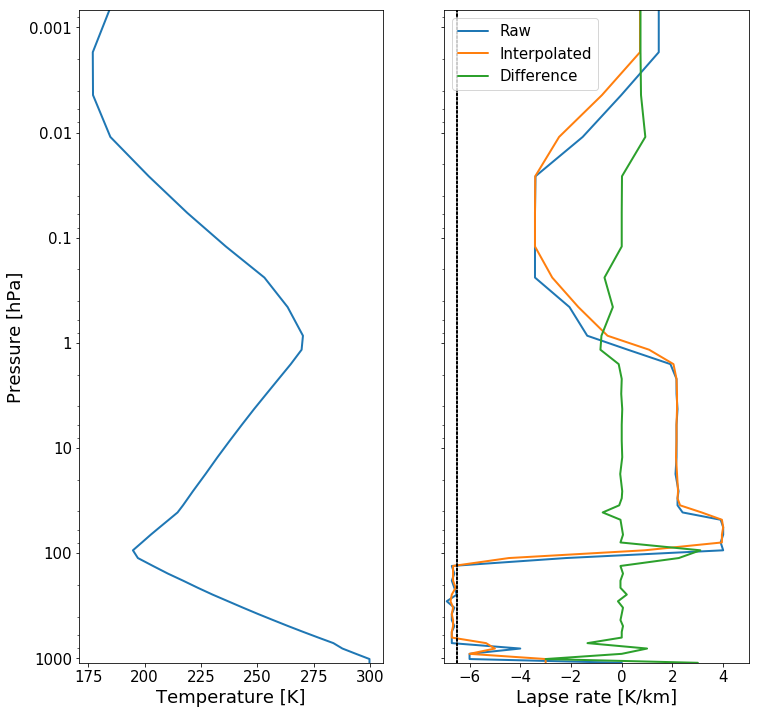

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import typhon.plots 

import conrad


gf = xml.load('data/tropical.xml')
p = gf.grids[1]
z = typhon.arts.atm_fields_compact_get(['z'], gf).ravel()
T = typhon.arts.atm_fields_compact_get(['T'], gf).ravel()

plt.style.use(typhon.plots.styles('typhon'))

lapse_rate = np.diff(T) / np.diff(z)

l1 = np.append(lapse_rate, lapse_rate[-1])

l2 = typhon.math.interpolate_halflevels(lapse_rate)
l2 = np.append(l2[0], l2)
l2 = np.append(l2, l2[-1])

plt.style.use(typhon.plots.styles('typhon'))

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(12, 12))
typhon.plots.profile_p_log(p, T, ax=ax1)
ax1.set_xlabel('Temperature [K]')
typhon.plots.profile_p_log(p, l1 * 1000, label='Raw', ax=ax2)
typhon.plots.profile_p_log(p, l2 * 1000, label='Interpolated', ax=ax2)
typhon.plots.profile_p_log(p, (l1 - l2) * 1000, label='Difference', ax=ax2)
#ax2.set_ylim(1100e2, 200e2)
ax2.set_xlim(-7, 5)
ax2.set_xlabel('Lapse rate [K/km]')
ax2.legend()
ax2.axvline(-6.5, color='black', linestyle='dotted')

In [ ]:
def plot_fluxes(z, T, flux, heating, ax=None):
    if ax is None:
        ax = plt.gca()
        
    typhon.plots.profile_z(z, typhon.math.interpolate_halflevels(flux), label='Flux')
    typhon.plots.profile_z(z, heating, label='Heating')
    typhon.plots.profile_z(z, typhon.math.interpolate_halflevels(get_lapse_rate(T, z)) * 1000, label='Lapse rate')
    ax.axvline(-6.5, color='k')
    ax.axvline(0, linewidth=0.5, color='k', alpha=0.5)
    ax.set_xlim(-15, 7)
    ax.legend(loc='upper left')
    

def get_lapse_rate(T, z):
    lr = np.diff(T) / np.diff(z)
    lr = np.append(lr[0], lr)
    return np.append(lr, lr[-1])

def get_convective_flux(T, z, critical_lapse_rate=-0.0065):
    lr = get_lapse_rate(T, z)
    return np.clip(critical_lapse_rate - lr, 0, None) 

def get_convective_heating(T, z):
    return np.diff(c_flux) * np.append(np.diff(z), z[-1])
    

z = np.linspace(0, 15e3, 10)
T = 300 + -0.0065 * z

T *= np.linspace(1.2, 1, T.size)

plt.style.use(typhon.plots.styles('typhon'))
for i in range(500):
    c_flux = get_convective_flux(T, z)
    c_htngrt = get_convective_heating(T, z)
    
    # fig, ax = plt.subplots(figsize=(4, 4))
    # plot_fluxes(z, T, c_flux * 1000, c_htngrt)
    # ax.set_title(i)

    T += -0.1 * c_htngrt
    
fig, ax = plt.subplots(figsize=(4, 4))
plot_fluxes(z, T, c_flux * 1000, c_htngrt)
ax.set_title(i)

In [ ]:
data = Dataset('results/test-convective.nc')

time = data.variables['time'][:]
p = data.variables['plev'][:]
T = data.variables['T'][:]
net_htngrt = data.variables['net_htngrt'][:]

dT = np.diff(T, axis=0)

fig, [ax2, ax1] = plt.subplots(2, sharex=True, figsize=(10, 8))
sm = ax1.pcolormesh(time, p, dT.T, cmap='seismic', rasterized=True)
cb = fig.colorbar(sm, label='$\Delta$ T [K/day]', ax=ax1)
typhon.plots.center_colorbar(cb)
ax1.set_yscale('log')
ax1.set_ylabel('Pressure [hPa]')
ax1.set_xlabel('Hours passed')
ax1.invert_yaxis()
ax1.set_xlim(time[0], time[500])
ax1.yaxis.set_major_formatter(typhon.plots.HectoPascalLogFormatter())
ax1.yaxis.set_minor_formatter(typhon.plots.HectoPascalLogFormatter())


sm = ax2.pcolormesh(time, p, net_htngrt.T, cmap='seismic', rasterized=True)
cb = fig.colorbar(sm, label='$\Delta$ T$_{rad}$ [K/day]', ax=ax2)
typhon.plots.center_colorbar(cb)
ax2.set_yscale('log')
ax2.set_ylabel('Pressure [hPa]')
ax2.invert_yaxis()
ax2.set_xlim(time[0], time[500])
ax2.yaxis.set_major_formatter(typhon.plots.HectoPascalLogFormatter())
ax2.yaxis.set_minor_formatter(typhon.plots.HectoPascalLogFormatter())

fig.savefig('plots/temperature_change.pdf')

In [ ]:
data = Dataset('results/test-convective.nc')

time = data.variables['time'][:]
p = data.variables['plev'][:]
# ph = np.hstack((p[0], typhon.math.interpolate_halflevels(p), p[-1]))
ph = np.hstack((p[0], typhon.math.interpolate_halflevels(p), 0))
dph = np.diff(ph)
z = data.variables['z'][0, :]
dz = np.diff(z)
T = data.variables['T'][0, :]
net_htngrt = data.variables['lw_htngrt'][0, :]
rho = typhon.physics.density(p, T)
c_p = 1003.5
rcday = (86400 * typhon.constants.g / c_p)

sw_flxd = data.variables['lw_flxd'][0, :]
sw_flxu = data.variables['lw_flxu'][0, :]

# Consider using this...
# sw_flxd = np.hstack((0, sw_flxd))
# sw_flxu = np.hstack((0, sw_flxu))
# heating = -(np.diff(sw_flxu) - np.diff(sw_flxd))

fig, ax = plt.subplots(figsize=typhon.plots.figsize(6, portrait=True))
ax.plot(sw_flxu, z, label='Up')
ax.plot(-sw_flxd, z, label='Down')
ax.plot(sw_flxu - sw_flxd, z, label='Net')
ax.legend()
ax.set_yscale('log')
#ax.set_ylim(p.max(), p.min())


heating = np.zeros(p.size)
for i in range(p.size - 1):
    heating[i] = -(sw_flxu[i] - sw_flxu[i + 1] - sw_flxd[i] + sw_flxd[i + 1])
heating *= rcday / dph
    
# fig, ax = plt.subplots(figsize=typhon.plots.figsize(6, portrait=True))
# ax.plot(heating / dph * typhon.constants.g / c_p, z, label='Up')
# ax.set_yscale('log')


# arbitrary correction factor
#heating /= 4.3e3

fig, ax = plt.subplots(figsize=typhon.plots.figsize(6, portrait=True))
typhon.plots.profile_p_log(p, net_htngrt, label='PSRAD', ax=ax)
typhon.plots.profile_p_log(p, heating, label='from fluxes', ax=ax)
typhon.plots.profile_p_log(p, net_htngrt - heating, label='difference', color='k', linestyle=':', ax=ax)
# ax.set_ylim(0.5e2, p.min())
ax.set_ylim(p.max(), p.min())
#ax.set_xlim(-5, 30)
ax.set_xlabel('Heatingrate [K/day]')
ax.legend()
ax.grid(which='both')
fig.savefig('plots/own_heatingrates.pdf')



fig, ax = plt.subplots(figsize=typhon.plots.figsize(6, portrait=True))
ax.plot(net_htngrt, z)
ax.set_yscale('log')
ax.grid(which='both')
ax.set_xlim(-15, 2)

In [ ]:
p = data.variables['plev'][:]
ph = typhon.math.interpolate_halflevels(p)
ph = np.hstack((p[0], ph, p[-1]))

i = np.arange(p.size)
ih = np.hstack((0, typhon.math.interpolate_halflevels(i), p.size - 0.5))

fig, ax = plt.subplots(figsize=(4, 6))
typhon.plots.profile_p_log(ph, ih, marker='o', label='Half level')
typhon.plots.profile_p_log(p, i, marker='x', label='Full level')
ax.legend()
ax.set_ylim(1150e2, 750e2)
# ax.set_ylim(0.12e2, 0.08e2)

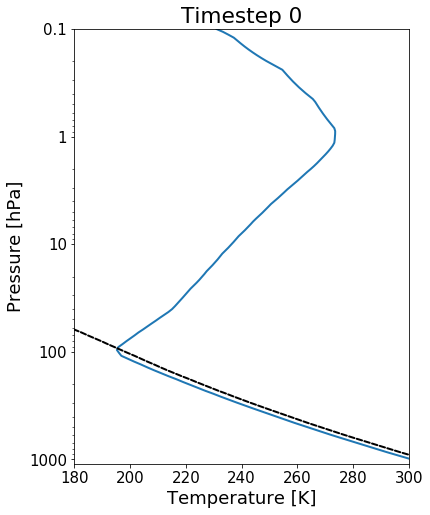

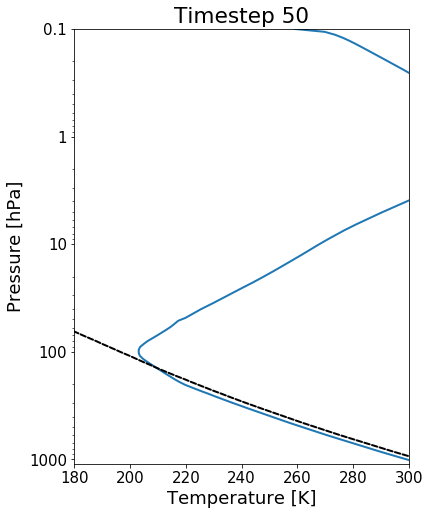

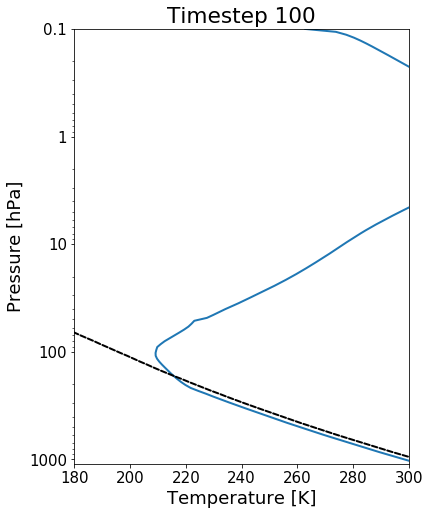

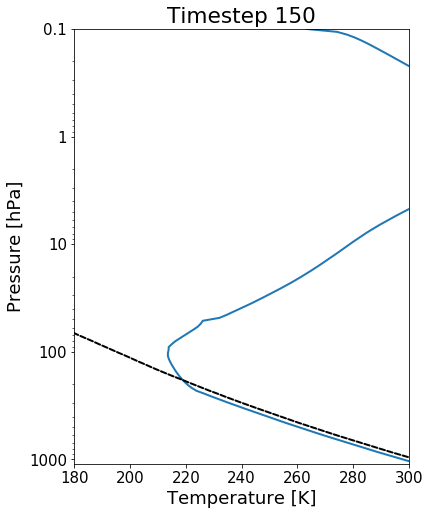

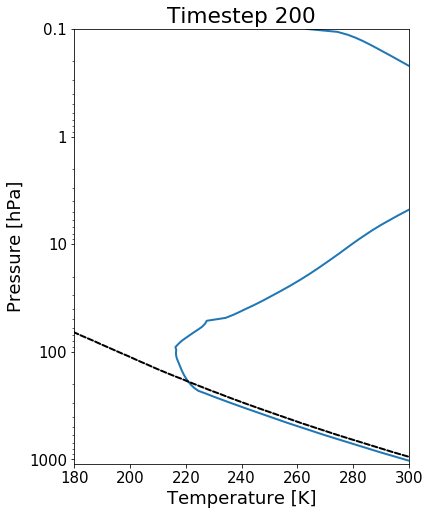

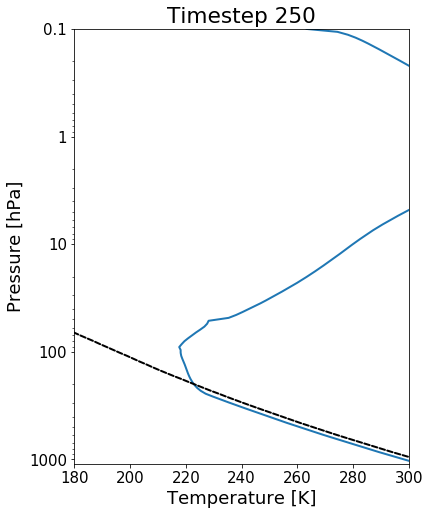

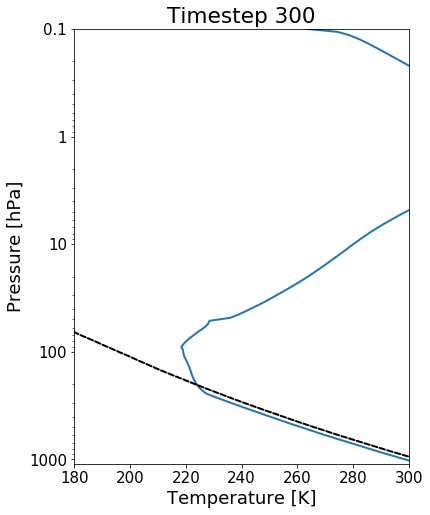

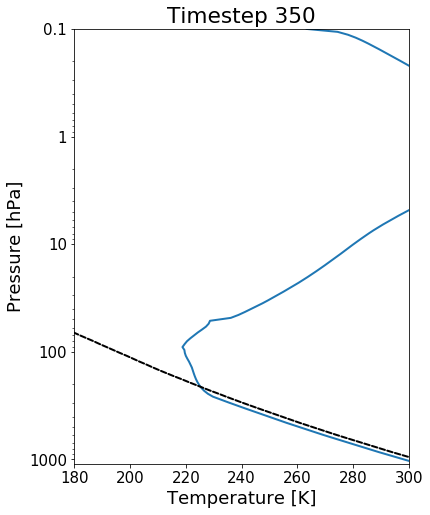

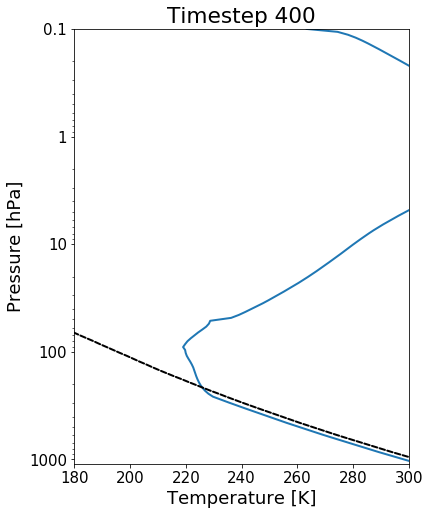

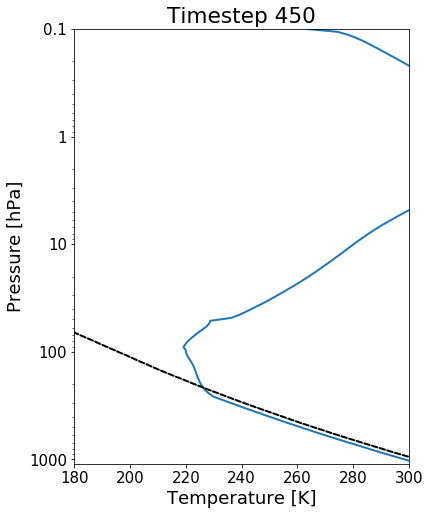

In [2]:
data = Dataset('results/test.nc')

p = data.variables['plev'][:]
z = data.variables['z'][0, :]
T = data.variables['T'][:]

for t in range(0, 500, 50):
    fig, ax = plt.subplots(figsize=(6, 8))
    typhon.plots.profile_p_log(p, T[t, :])
    typhon.plots.profile_p_log(p, T[t, 0] - 0.0065 * z, linestyle='dashed', color='black')
    ax.set_xlabel('Temperature [K]')
    ax.set_xlim(180, 300)
    ax.set_ylim(p.max(), p.min())
    ax.set_title('Timestep {}'.format(t))